Here we are going to solve a simple Eigenvalue problem defined as:

\begin{equation}
\frac{d^2  y(x)}{dx^2} = - \lambda y(x)
\end{equation}

where $\lambda$ is the eigenvalue of the problem. Given the boundary conditions: $y(0) = y(L) = 0 $

**THE EXACT SOLUTION**

The exact solution is given as
\begin{equation}
y_{n} (x) = A_{n} sin(\frac{n \pi x}{L})
\end{equation}
and
\begin{equation}
\lambda_{n} =  \left( \frac{n \pi}{L}\right)^2
\end{equation}
with

\begin{equation}
A_n = \sqrt{\frac{2}{L}}
\end{equation}

Now, we consider the problem for $L = \pi$

In [ ]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy


#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))


cuda
Tesla T4


In [ ]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f,x):
  gouts = torch.ones(x.shape, dtype=torch.float, device = device)
  return grad([f],[x],grad_outputs=gouts, create_graph=True)[0]

In [ ]:
#function to define the peaks
def peaks(f):
  #tf = f.flatten() #To reshape the tensor for the torch.diff() function
  s = abs(torch.diff(torch.sign(torch.diff(f))))/2
  return torch.sum(s)


In [ ]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  dt1 = t - t0
  dt2 = t - tf
  f = (1-torch.exp(-dt1))*(1-torch.exp(-dt2))
  psi_hat = bound + f*N1
  return psi_hat

In [ ]:
#The loss function definition
def hamEqs_Loss(t,psi):
  psi_x = dfx(psi,t)
  psi_xx = dfx(psi_x,t)
  E  = (torch.dot(psi[:,0], -psi_xx[:,0]))/(torch.dot(psi[:,0],psi[:,0])) ####
  f = (psi_xx) + (E)*psi
  L = (f.pow(2)).mean()
  return L,E

In [ ]:
#Defining the NN architecture without symmetry
class qNN(torch.nn.Module):
  def __init__(self,layers):
    super(qNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      #nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(layers)-2):
      z = self.linears[i](a)
      a = self.activation(z)
    a = self.linears[-1](a)
    return a

In [ ]:
#Defining the hyperparameters
t0 =0; tf = torch.pi; xbc = 0
col_pts = 201; layers = [1,100,100,1]; lr = 1e-2; epochs =120000
breakpoints = np.array([9000, 20000, 40000, 60000, 80000, 100000])

In [ ]:
#def single_train(t0,tf,x1,layers,epochs,col_pts,lr,batch_number = 1)
model = qNN(layers)
model.to(device)
print(model)
#params = list(model.parameters())
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 100, verbose = True)

qNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [ ]:
for name, param in model.named_parameters():
  print(f'Parameter: {name}, Gradient_norm: {param.grad}')

Parameter: linears.0.weight, Gradient_norm: None
Parameter: linears.0.bias, Gradient_norm: None
Parameter: linears.1.weight, Gradient_norm: None
Parameter: linears.1.bias, Gradient_norm: None
Parameter: linears.2.weight, Gradient_norm: None
Parameter: linears.2.bias, Gradient_norm: None


In [ ]:
def save_checkpoint(state, filename='last_checkpoint.pth.tar'):
  print('=========================')
  print('Saving checkpoint')
  print('=========================')
  torch.save(state, filename)

In [ ]:
#checkpoint = torch.load('last_checkpoint.pth.tar')
##qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
#current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']
#En_history = checkpoint['En_history'];dic = checkpoint['dic']
#En_counter = [En_history[9000], En_history[20000], En_history[40000],En_history[60000]]

In [ ]:
En_counter

[1.0000020265579224, 4.001978397369385, 8.999263763427734, 15.998839378356934]

In [ ]:
#To learn multiple eigenvlues and eigenvectors, we will need both the orthogonality and orthonormality ppty
def nn_train(qNN,t0,tf,xbc,col_pts,checkpoints, epochs,t):
  mod1 = 0 #placeholder to save the best model
  En_history = [] #To store the eigenvalues as it is optimized
  SE_loss_hist = [] #To store the pde loss
  internal_loss_hist = [] #To compute loss for rolling mean
  Loss_hist = []#To store the total loss after every epoch
  t_rand = t.to(device) #The collocation points
  t_rand.requires_grad =True
  t_plot = t_rand.cpu().detach().numpy() #For training plots
  load_model = False #To load the model from the last checkpoint


  orth_counter = 0
  En_counter = []
  #Dictionary for storing the learned eigenfunction
  dic = {}

  stime = time.time()
  if load_model:
    print('=========================')
    print('Loading checkpoint')
    print('=========================')
    checkpoint = torch.load('last_checkpoint.pth.tar')
    qNN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
    current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']
    En_history = checkpoint['En_history'];dic = checkpoint['dic']
    En_counter = [En_history[9000], En_history[20000], En_history[40000],En_history[60000]]
  #for iter in range(current+1,epochs + 1): #Comment this line if load_model = False
  for iter in range(epochs + 1): #Comment this line if True
    NN = qNN(t_rand) #The forward pass
    loss = 0.0

    #Getting the parametric solution
    psi =parametricSolutions(t_rand,qNN,t0,tf,xbc).to(device)
    psi_x = dfx(psi,t_rand)
    psi_xx = dfx(psi_x,t_rand)

    pde_loss, En = hamEqs_Loss(t_rand,psi)
    En_history.append(En.cpu().detach().numpy().item())
    #Getting the loss after the forward pass
    SE_loss_hist.append(pde_loss)
    internal_loss_hist.append(pde_loss.cpu().detach().numpy())

    criteria_loss = pde_loss/torch.sqrt(torch.dot(psi[:,0],psi[:,0])) #The loss for the patience condition

    #Adding the normalization as a regularization term
    NT = ( 1 - ((tf - t0) * torch.sqrt(torch.dot(psi[:,0],psi[:,0]))/ col_pts) ).pow(2)
    #NT = 3000*(trapezoidal(psi.pow(2)) -  1)**2

    node1_loss = torch.abs((torch.sum(torch.abs(torch.diff(torch.sign(torch.diff(psi[:,0]))))/2) - 1)) #loss of the peaks
    total_loss = criteria_loss + NT + node1_loss


    #Outputing the training values
    if iter == 0:
      psi = torch.ones_like(psi)

    #if iter == current + 1:
    #  qNN.apply(weights_init)

    for index, breakpoint in enumerate(breakpoints):
      if iter == breakpoint and orth_counter == index:
        dic[index] = copy.deepcopy(qNN)
        En_counter.append(En_history[-1])
        orth_counter += 1
        psi_i = parametricSolutions(t_rand, dic[index],t0,tf,xbc)
        psi = psi_i * (t_rand - torch.pi/2)
        print('==========================================')
        print(f"Learned {index+1} Eigenvalues")
        print('==========================================')
        #saving a checkpoint for future iterations
        #checkpoint = {
        #    'state_dict': qNN.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': iter, 'Loss_hist': Loss_hist,
        #    'orth_counter': orth_counter, 'En_history': En_history, 'dic': dic, 'En_counter': En_counter
        #}
        #save_checkpoint(checkpoint)




    #Calculating condition for the lossses
    #Getting the condition for the en_loss
    if orth_counter > 0:
      diff = ((torch.dot(psi[:,0], -psi_xx[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) - En_counter[-1]
      #en_loss = 0 if diff > 0 else 5*torch.exp(-diff)
      en_loss = 5*torch.clamp(torch.sign(-diff), min=0)*torch.exp(-diff)
      psi_sum = 0

      for i in range(orth_counter):
        psi_sum += parametricSolutions(t_rand,dic[i],t0,tf,xbc)

      #Normalizing the orthogonal loss
      normf = (torch.sqrt(torch.dot(psi_sum[:,0], psi_sum[:,0])) * torch.sqrt(torch.dot(psi[:,0], psi[:,0])))
      ortho_loss  =  100*torch.sqrt(torch.dot(psi_sum[:,0], psi[:,0]).pow(2))/normf
      noden_loss = torch.abs((torch.sum(torch.abs(torch.diff(torch.sign(torch.diff(psi[:,0]))))/2) - 1 - orth_counter))
      total_loss +=  ortho_loss + noden_loss - node1_loss + en_loss



    if iter % 300 == 0:
      #Plot the network after every 300 iterations
      #fig,ax1 = plt.subplots(figsize=(4,3))
      #psi_plot = psi.cpu().detach().numpy()
      #ax1.plot(t_plot, psi_plot, label= f'Total_loss: {total_loss.cpu().detach().numpy():.5f} ')
      #ax1.set_title(f'Epoch: {iter}, En: {En_history[-1]:.7f}, oc: {orth_counter}')
      #ax1.legend()
      #plt.show()
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]:.7f}')
      print(f'oc: {orth_counter}')
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.cpu().detach().numpy())
      if orth_counter > 0:
        print('ortho_loss: ', ortho_loss.cpu().detach().numpy())
        print('en_loss: ',en_loss.cpu().detach().numpy())
      print('pde_loss: ', criteria_loss.cpu().detach().numpy())
      print('NT: ', NT.cpu().detach().numpy())
      print('nodal_loss1: ',node1_loss.cpu().detach().numpy()) if orth_counter == 0 else print('nodal_lossn: ',noden_loss.cpu().detach().numpy())
      for name, param in qNN.named_parameters():
        if param.grad is not None:
          print(f'Parameter: {name}, Gradient Norm: {torch.norm(param.grad)}')



    #Backward propagation
    optimizer.zero_grad()
    total_loss.backward()
    #Introducing Gradient clipping
    max_norm = 5.0
    torch.nn.utils.clip_grad_norm_(qNN.parameters(), max_norm)
    optimizer.step()
    loss += total_loss.cpu().detach().numpy()


    #Storing the loss after each iteration
    Loss_hist.append(loss)
    #Scheduling the learning rate
    #scheduler.step(total_loss)


  #Storing the final eigenfunction and eigenvalue
  dic[orth_counter] = copy.deepcopy(qNN)
  En_counter.append(En_history[-1])


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return Loss_hist, En_history, En_counter, dic

In [ ]:
grid = torch.linspace(0,torch.pi, col_pts).view(-1,1)
Loss, eig_vals, eig_count, qPINN = nn_train(model,t0,tf,xbc,col_pts,breakpoints,epochs, grid)

Loading checkpoint
--------------------------------------------
Epoch: 60300
En: 16.1961403
oc: 4
--------------------------------------------
Total_loss:  84.26151
ortho_loss:  68.557304
en_loss:  0.0
pde_loss:  12.569142
NT:  2.1350636
nodal_lossn:  1.0
Parameter: linears.0.weight, Gradient Norm: 2.135751485824585
Parameter: linears.0.bias, Gradient Norm: 3.423927068710327
Parameter: linears.1.weight, Gradient Norm: 2.864439010620117
Parameter: linears.1.bias, Gradient Norm: 0.3712667226791382
Parameter: linears.2.weight, Gradient Norm: 0.5976159572601318
Parameter: linears.2.bias, Gradient Norm: 0.12366778403520584
--------------------------------------------
Epoch: 60600
En: 16.4611168
oc: 4
--------------------------------------------
Total_loss:  82.82429
ortho_loss:  62.071148
en_loss:  0.0
pde_loss:  16.397203
NT:  3.3559368
nodal_lossn:  1.0
Parameter: linears.0.weight, Gradient Norm: 1.418277382850647
Parameter: linears.0.bias, Gradient Norm: 3.902193069458008
Parameter: line

In [ ]:
eig_count

[1.0000020265579224,
 4.001978397369385,
 8.999263763427734,
 15.998839378356934,
 24.998210906982422,
 35.966407775878906,
 48.953548431396484]

##Predicted Vs Exact

In [ ]:
#Defining the exact solution

def exact(x,n):
  return np.sqrt(2/np.pi) *np.sin(n*x)

In [ ]:
tTest = torch.linspace(0,torch.pi,100).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi1 =parametricSolutions(tTest,qPINN[0].cpu(),t0,tf,xbc).data.numpy()
psi2 =parametricSolutions(tTest,qPINN[1].cpu(),t0,tf,xbc).data.numpy()
psi3 = parametricSolutions(tTest,qPINN[2].cpu(),t0,tf,xbc).data.numpy()
psi4 = parametricSolutions(tTest,qPINN[3].cpu(),t0,tf,xbc).data.numpy()
psi5 = parametricSolutions(tTest,qPINN[4].cpu(),t0,tf,xbc).data.numpy()
psi6 = parametricSolutions(tTest,qPINN[5].cpu(),t0,tf,xbc).data.numpy()
psi7 = parametricSolutions(tTest,qPINN[6].cpu(),t0,tf,xbc).data.numpy()

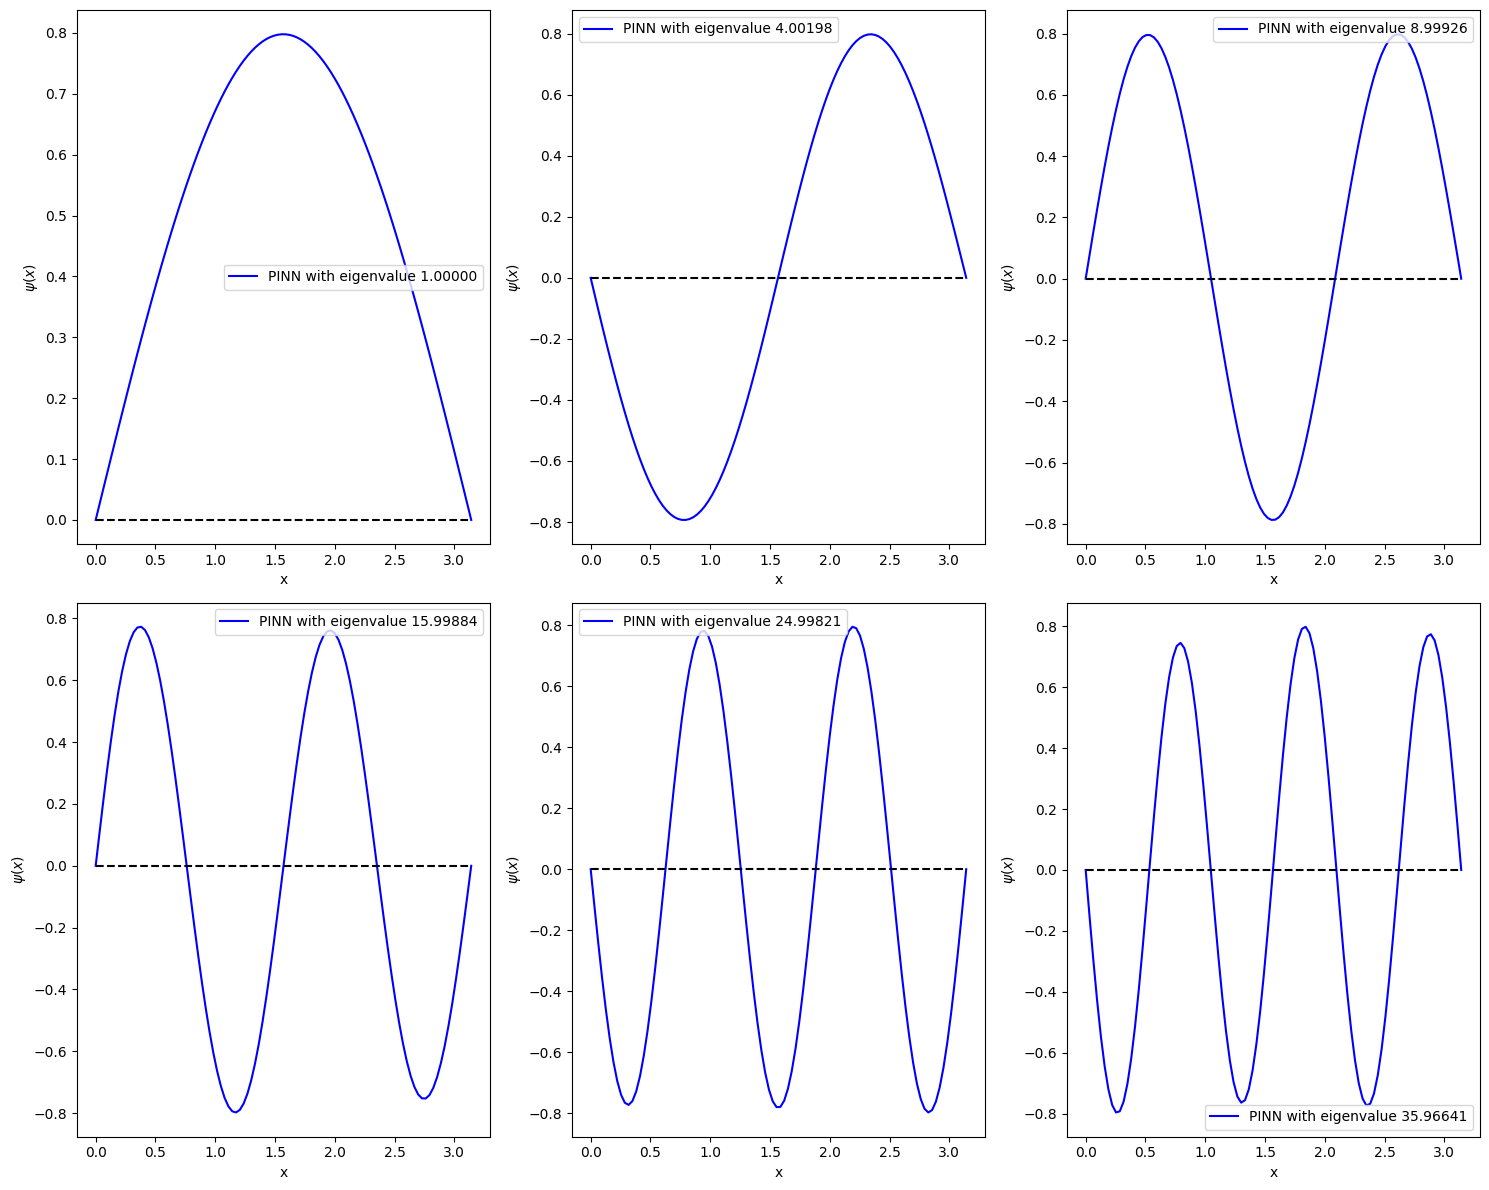

In [ ]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculate the total number of subplots needed
total_subplots = num_rows * num_cols

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterate over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_count[:total_subplots]):
    psi = parametricSolutions(tTest, qPINN[index].cpu(), t0, tf, xbc).data.numpy()
    row_index = index // num_cols  # Calculate row index
    col_index = index % num_cols   # Calculate column index

    # Plot on the corresponding subplot
    ax = axes[row_index, col_index]
    ax.plot(t_net, -np.sqrt(2/np.pi)*psi/max(abs(psi)), color='blue', label=f'PINN with eigenvalue {eig:.5f}')
    ax.plot(t_net, np.zeros(len(t_net)), '--k')
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


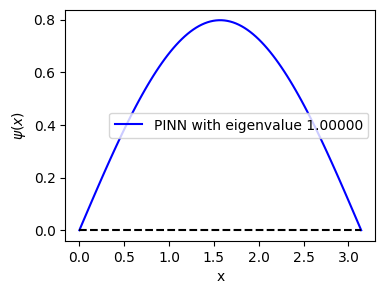

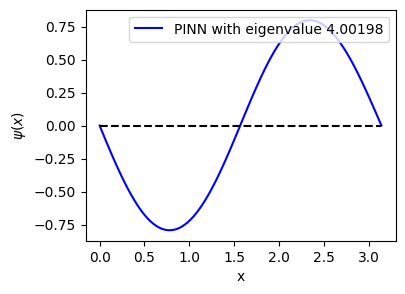

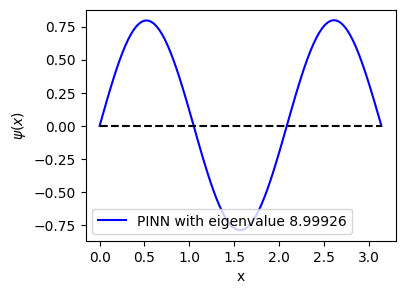

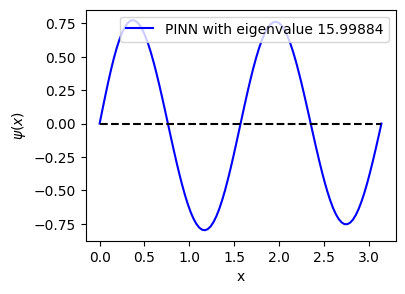

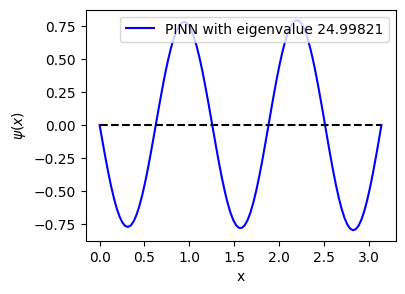

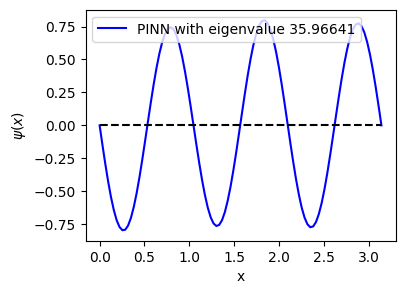

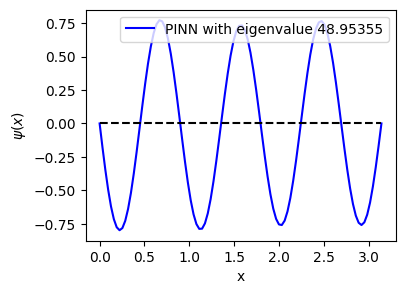

In [ ]:
for index,eig in enumerate(eig_count):
  psi = parametricSolutions(tTest,qPINN[index].cpu(),t0,tf,xbc).data.numpy()
  fig, ax1 = plt.subplots(figsize=(4,3))
  ax1.plot(t_net, -np.sqrt(2/np.pi)*psi/max(abs(psi)), color = 'blue', label =f'PINN with eigenvalue {eig:.5f}')
  ax1.plot(t_net, np.zeros(len(t_net)),'--k')
  ax1.set_xlabel('x',color='black')
  ax1.set_ylabel('$\psi(x)$',color='black')
  ax1.tick_params(axis='y', color='black')
  ax1.legend()
  plt.show()



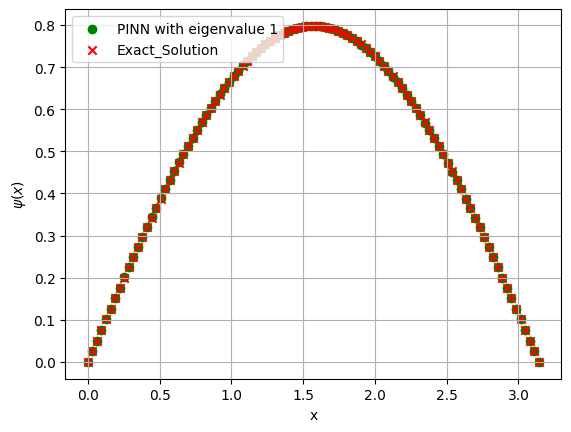

In [ ]:
y1 = exact(t_net,1)
fig, ax1 = plt.subplots()
ax1.scatter(t_net, -np.sqrt(2/np.pi)*psi1/max(abs(psi1)), color='green', label = 'PINN with eigenvalue 1')
ax1.scatter(t_net, y1,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

plt.grid('on')

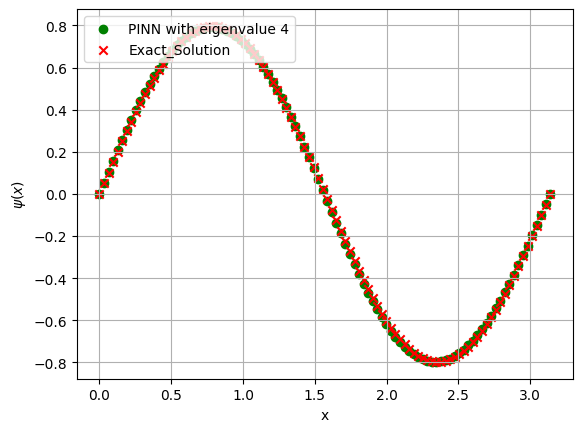

In [ ]:
y2 = exact(t_net,2)
fig, ax1 = plt.subplots()
ax1.scatter(t_net, np.sqrt(2/np.pi)*psi2/max(abs(psi2)), color='green', linewidth=1, label = 'PINN with eigenvalue 4')
ax1.scatter(t_net, y2,marker = 'x',color='red',label='Exact_Solution')

#ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=2)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

plt.grid('on')

In [ ]:
y3 = exact(t_net,3);y4 = exact(t_net,4)
y5 = exact(t_net,5);y6 = exact(t_net,6); y7 = exact(t_net,7)

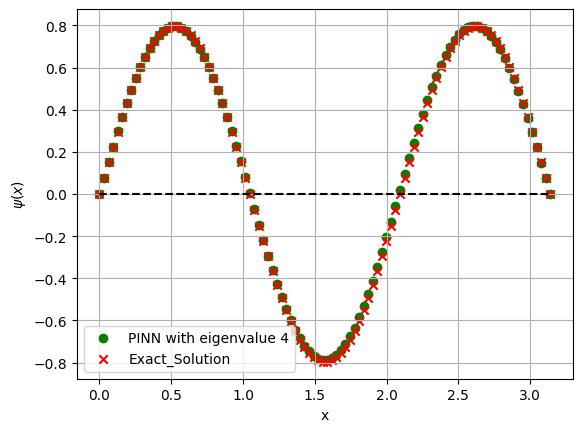

In [ ]:
fig, ax2 = plt.subplots()
ax2.scatter(t_net, -np.sqrt(2/np.pi)*psi3/max(abs(psi3)), color='green', linewidth=1, label = 'PINN with eigenvalue 9')
ax2.scatter(t_net, y3,marker = 'x',color='red',label='Exact_Solution')
ax2.plot(t_net, np.zeros(len(t_net)),'--k')
ax2.set_xlabel('x',color='black')
ax2.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax2.tick_params(axis='y', color='black')
ax2.legend(loc = 'lower left')

plt.grid('on')

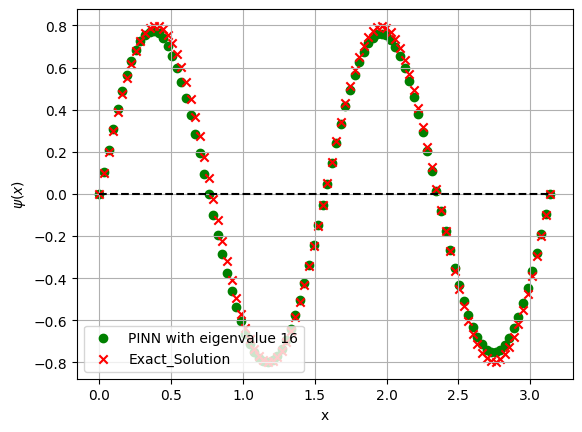

In [ ]:
fig, ax2 = plt.subplots()
ax2.scatter(t_net, -np.sqrt(2/np.pi)*psi4/max(abs(psi4)), color='green', linewidth=1, label = 'PINN with eigenvalue 16')
ax2.scatter(t_net, y4,marker = 'x',color='red',label='Exact_Solution')
ax2.plot(t_net, np.zeros(len(t_net)),'--k')
ax2.set_xlabel('x',color='black')
ax2.set_ylabel('$\psi(x)$',color='black')
#ax1.set_xlim(0,3.2)
ax2.tick_params(axis='y', color='black')
ax2.legend(loc = 'lower left')

plt.grid('on')

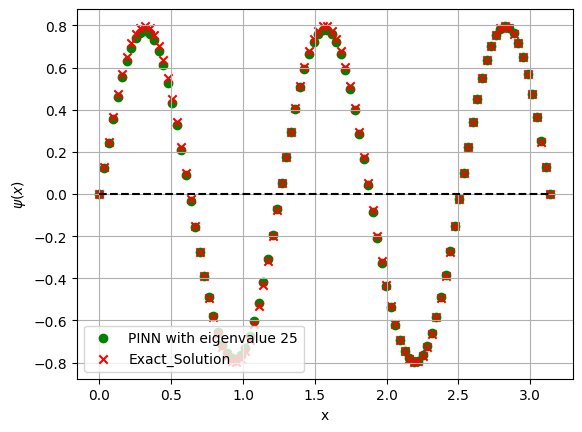

In [ ]:
fig, ax2 = plt.subplots()
ax2.scatter(t_net, np.sqrt(2/np.pi)*psi5/max(abs(psi5)), color='green', linewidth=1, label = 'PINN with eigenvalue 25')
ax2.scatter(t_net, y5,marker = 'x',color='red',label='Exact_Solution')
ax2.plot(t_net, np.zeros(len(t_net)),'--k')
ax2.set_xlabel('x',color='black')
ax2.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,3.2)
ax2.tick_params(axis='y', color='black')
ax2.legend(loc = 'lower left')

plt.grid('on')

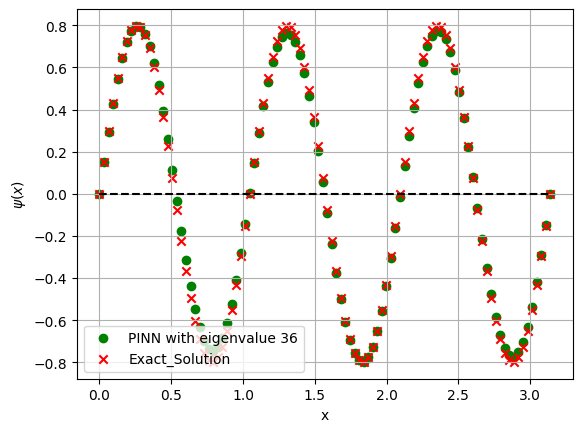

In [ ]:
fig, ax2 = plt.subplots()
ax2.scatter(t_net, np.sqrt(2/np.pi)*psi6/max(abs(psi6)), color='green', linewidth=1, label = 'PINN with eigenvalue 36')
ax2.scatter(t_net, y6,marker = 'x',color='red',label='Exact_Solution')
ax2.plot(t_net, np.zeros(len(t_net)),'--k')
ax2.set_xlabel('x',color='black')
ax2.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,3.2)
ax2.tick_params(axis='y', color='black')
ax2.legend(loc = 'lower left')

plt.grid('on')

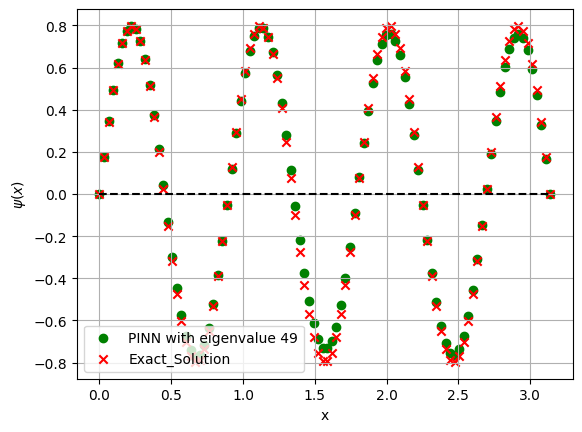

In [ ]:
fig, ax2 = plt.subplots()
ax2.scatter(t_net, np.sqrt(2/np.pi)*psi7/max(abs(psi7)), color='green', linewidth=1, label = 'PINN with eigenvalue 49')
ax2.scatter(t_net, y7,marker = 'x',color='red',label='Exact_Solution')
ax2.plot(t_net, np.zeros(len(t_net)),'--k')
ax2.set_xlabel('x',color='black')
ax2.set_ylabel('$\psi(x)$',color='black')
ax1.set_xlim(0,3.2)
ax2.tick_params(axis='y', color='black')
ax2.legend(loc = 'lower left')

plt.grid('on')